In [1]:
!pip install --user uproot
!pip install --user pylorentz

In [2]:
import sys
sys.path.append("/eos/home-m/kcollie/.local/lib/python2.7/site-packages")

In [3]:
import uproot 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

from pylorentz import Momentum4
from pylorentz import Position4

In [4]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
#tree2 = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]


#These are new trees, added by Danny on 13/10
#tree3=uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]  
#note, instead of the first t we can have e,m, different decay modes

In [5]:
# define what variables are to be read into the dataframe

variables = [ "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", #leading charged pi 4-momentum
              "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", #subleading charged pi 4-momentum
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1", #leading neutral pi 4-momentum
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2", #subleading neutral pi 4-momentum
              "ip_x_1", "ip_y_1", "ip_z_1",        #leading impact parameter
              "ip_x_2", "ip_y_2", "ip_z_2",        #subleading impact parameter
              "y_1_1", "y_1_2",    # ratios of energies
                "aco_angle_1",  #acoplanarity angle
             "tau_decay_mode_1","tau_decay_mode_2",
             "mva_dm_1","mva_dm_2"
             ]

df = tree.pandas.df(variables)

df = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
]
#df2 = tree2.pandas.df(variables)

#tree3 should be more comprehensive and complete as it includes all decay types and more
#info for tau->a1 decays. Again we save the same variables for now

#df3 = tree3.pandas.df(variables)

#combine VBF and ggH events

#df = pd.concat([df,df2], ignore_index=True)

In [6]:
df.head()

,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,...,ip_x_2,ip_y_2,ip_z_2,y_1_1,y_1_2,aco_angle_1,tau_decay_mode_1,tau_decay_mode_2,mva_dm_1,mva_dm_2
entry,,,,,,,,,,,,,,,,,,,,,
4,26.184192,5.249920,-12.394966,-22.458754,52.305565,-10.016787,40.401790,-31.673523,95.932667,20.387663,...,-0.000894,0.000668,0.000903,0.571162,-0.773942,5.927902,1,1,1,1
15,3.912128,3.186334,0.086207,-2.263873,32.211659,7.872188,29.660602,9.790244,64.282235,52.942869,...,-0.002586,0.001020,-0.000611,0.885265,-0.339467,5.015406,1,1,1,1
26,20.389432,12.846308,15.714182,1.935544,5.313678,-4.517069,-2.251007,1.656731,35.041365,21.823335,...,0.004199,0.003093,0.014879,0.264328,0.760691,3.019532,1,1,1,1
39,4.532329,-1.060811,2.501133,-3.625128,11.348225,-2.284085,-6.326895,-9.138714,102.977036,-25.022726,...,0.009565,-0.000590,-0.001876,0.915685,0.772376,2.650678,1,1,1,1
55,77.929050,28.100279,42.522791,58.950012,72.891011,8.689332,15.745896,70.637400,68.260095,25.125369,...,-0.020295,0.027176,-0.004810,-0.066140,0.534360,3.057700,1,1,1,1


Before any traning, let's try and reconstruct aco_angle_1 from the low level variable. 
$\mathbf{\lambda}^{\pm}=(0,\mathbf{j}^\pm)$ where $\mathbf{j}^\pm$ is the impact parameter vector defined as the vector btw the primary vertex (PV) and the point of closest approach (PCA).

Then we need to boost $\mathbf{\lambda}^{\pm}$ into the zero momentum frame (ZMF) thus giving $\mathbf{\lambda}^{*\pm}$. I will need to code a function to boost any four vector into the pion's ZMF. 

We will also need $\mathbf{q}^{*\pm}$ are the four-vector for charged pions, boosted in the ZMF. 

After that we will calculate $\mathbf{\lambda}^{*\pm}_{\perp}$ the transverse component of $\mathbf{\lambda}^{*\pm}$ w.r.t. $\mathbf{q}^{*\pm}$. 

Finally, the acoplanary angle $\phi_{CP}$ is definied by 

$\phi_{\mathrm{CP}}=\left\{\begin{array}{ll} \phi^{*} &  \text { if } O^{*} \geq 0 \\  360^{\circ}-\phi^{*} & \text { if } O^{*}<0 \end{array}\right\}$

with $O^{*}=\hat{q}^{*-} \cdot\left(\hat{\lambda}_{\perp}^{*+} \times \hat{\lambda}_{\perp}^{*-}\right)$.


Start with $\mathbf{j}^\pm$, check what we have in terms of available informations.

In [21]:
# Create our 4-vectors in the lab frame
pi_1 = Momentum4(df["pi_E_1"], df["pi_px_1"], df["pi_py_1"], df["pi_pz_1"])
pi_2 = Momentum4(df["pi_E_2"], df["pi_px_2"], df["pi_py_2"], df["pi_pz_2"])

#IP1 = Position4(np.zeros(len(df)), df["ip_x_1"], df["ip_y_1"], df["ip_z_1"])
#IP2 = Position4(np.zeros(len(df)), df["ip_x_2"], df["ip_y_2"], df["ip_z_2"])

#TODO: maybe remove these and uncomment above:
IP1 = Momentum4(df["pi0_E_1"], df["pi0_px_1"], df["pi0_py_1"], df["pi0_pz_1"])
IP2 = Momentum4(df["pi0_E_2"], df["pi0_px_2"], df["pi0_py_2"], df["pi0_pz_2"])

In [22]:
# Create 4-vectors in the ZMF
pi_T4M = pi_1 + pi_2

pi1_ZMF = pi_1.boost_particle(-pi_T4M)
pi2_ZMF = pi_2.boost_particle(-pi_T4M)

IP1_ZMF = IP1.boost_particle(-pi_T4M)
IP2_ZMF = IP2.boost_particle(-pi_T4M)

In [23]:
# Check we boosted correctly (spatial components should be 0)
P_Total = (pi1_ZMF+pi2_ZMF)
P_Total[:,23]

array([-2.45013505e+01,  1.77635684e-15,  7.99360578e-15,  3.90798505e-14])

In [24]:
# Find the transverse components
IP1_trans = np.cross(IP1_ZMF[1:,:].transpose(), pi1_ZMF[1:, :].transpose())
IP2_trans = np.cross(IP2_ZMF[1:,:].transpose(), pi2_ZMF[1:, :].transpose())

# Normalise the vectors
IP1_trans = IP1_trans/np.linalg.norm(IP1_trans, ord=2, axis=1, keepdims=True)
IP2_trans = IP2_trans/np.linalg.norm(IP2_trans, ord=2, axis=1, keepdims=True)

In [25]:
dot = np.sum(IP1_trans*IP2_trans, axis=1)
Phi_ZMF = np.arccos(dot)

In [26]:
# Calculate O
x = np.cross(IP1_trans, IP2_trans).transpose()*np.array(pi2_ZMF[1:, :])
big_O = np.sum(x, axis=0)

# Shift Phi based on O's sign
Phi_CP = np.where(big_O<0, 2*np.pi - Phi_ZMF, Phi_ZMF)

In [27]:
# Shift phi based on energy ratios
y_T = df['y_1_1']*df['y_1_2']
Phi_CP = np.where(y_T<0, 2*np.pi - Phi_CP, Phi_CP)

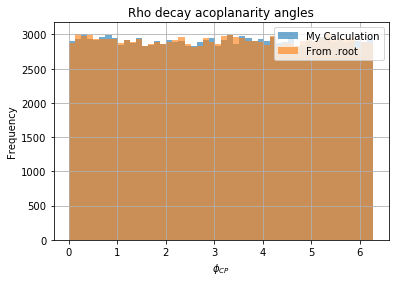

In [33]:
#Plot the histogram
aco_angle_1 = np.array(df['aco_angle_1'])

plt.figure()
plt.title("Rho decay acoplanarity angles")
plt.hist(Phi_CP, label="My Calculation", alpha=0.625, bins=50)
plt.hist(aco_angle_1, label="From .root", alpha=0.625, bins=50)
plt.xlabel(r"$\phi_{CP}$")
plt.ylabel("Frequency")
plt.grid()
plt.legend()
plt.savefig("KingsleyTask1.png")
plt.show()
plt.close()

In [49]:
#print the first few results vs given angles
for i in range(10):
    print("{:.4f} \t {:.4f}".format(Phi_CP[i], aco_angle_1[i]))

5.9279 	 5.9279
5.0154 	 5.0154
0.1221 	 3.0195
0.4909 	 2.6507
3.0577 	 3.0577
4.0362 	 5.3886
4.3666 	 5.0581
3.4759 	 3.4759
3.7483 	 5.6765
4.7794 	 4.6454


In [53]:
(Phi_CP - aco_angle_1)[:10]

array([ 1.68753900e-14,  1.15463195e-14, -2.89747202e+00, -2.15976258e+00,
        1.88737914e-13, -1.35242812e+00, -6.91484309e-01, -5.77315973e-15,
       -1.92823855e+00,  1.34072471e-01])

In [55]:
residuals = (Phi_CP - aco_angle_1)
print("Incorrect {:.2f}% of the time".format(100*np.count_nonzero(np.round(residuals, 4))/len(residuals)))

Incorrect 48.82% of the time


In [56]:
#print first few residuals
for i in range(10):
    print("{:.4f}".format(residuals[i]))

0.0000
0.0000
-2.8975
-2.1598
0.0000
-1.3524
-0.6915
-0.0000
-1.9282
0.1341
